In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'mps'
n_embd = 1

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz + n_embd # latent + y embedding
        self.embd = nn.Embedding(10, n_embd)
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x, y):
        x = torch.cat((x, self.embd(y)), dim=-1)
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784 + n_embd # Image + one hot label
        self.embd = nn.Embedding(10, n_embd)
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x, y):
        x = x.view(-1, 784)
        x = torch.cat((x, self.embd(y)), dim=-1)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (embd): Embedding(10, 1)
  (main): Sequential(
    (0): Linear(in_features=129, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (embd): Embedding(10, 1)
  (main): Sequential(
    (0): Linear(in_features=785, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
sch_d = lr_scheduler.StepLR(optim_d, step_size=10, gamma=0.95)

In [9]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [14]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:04, 25.04it/s]                                                                                                        


Epoch 1 of 200
Generator loss: 1.69525141, Discriminator loss: 0.85213833


118it [00:04, 25.39it/s]                                                                                                        


Epoch 2 of 200
Generator loss: 3.19421703, Discriminator loss: 0.97671445


118it [00:04, 26.20it/s]                                                                                                        


Epoch 3 of 200
Generator loss: 4.43030964, Discriminator loss: 0.83351300


118it [00:04, 25.98it/s]                                                                                                        


Epoch 4 of 200
Generator loss: 1.56861627, Discriminator loss: 1.50401602


118it [00:04, 25.92it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


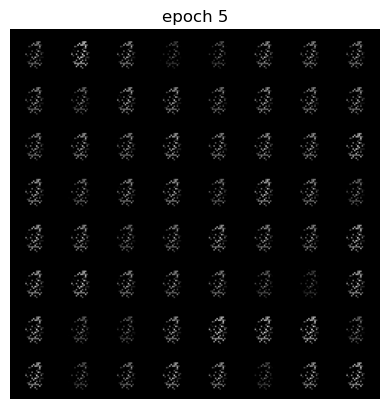

Epoch 5 of 200
Generator loss: 1.48910752, Discriminator loss: 1.35503412


118it [00:04, 25.09it/s]                                                                                                        


Epoch 6 of 200
Generator loss: 1.34902033, Discriminator loss: 1.18746146


118it [00:04, 26.23it/s]                                                                                                        


Epoch 7 of 200
Generator loss: 1.68539461, Discriminator loss: 0.86141288


118it [00:04, 26.07it/s]                                                                                                        


Epoch 8 of 200
Generator loss: 3.67913421, Discriminator loss: 1.01539412


118it [00:04, 25.90it/s]                                                                                                        


Epoch 9 of 200
Generator loss: 1.11092619, Discriminator loss: 1.09909610


118it [00:04, 26.03it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


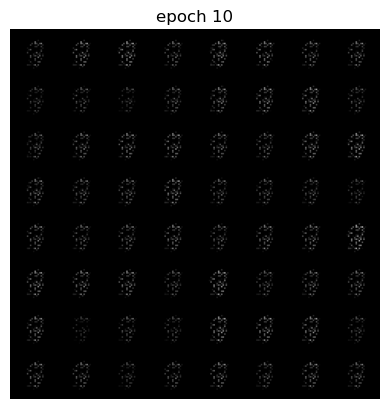

Epoch 10 of 200
Generator loss: 1.56014376, Discriminator loss: 0.96513212


118it [00:04, 25.56it/s]                                                                                                        


Epoch 11 of 200
Generator loss: 1.48137844, Discriminator loss: 1.12236361


118it [00:04, 26.10it/s]                                                                                                        


Epoch 12 of 200
Generator loss: 1.51556937, Discriminator loss: 1.05866833


118it [00:04, 25.85it/s]                                                                                                        


Epoch 13 of 200
Generator loss: 2.88619252, Discriminator loss: 0.82873120


118it [00:04, 26.11it/s]                                                                                                        


Epoch 14 of 200
Generator loss: 2.57127554, Discriminator loss: 0.85149236


118it [00:04, 25.87it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


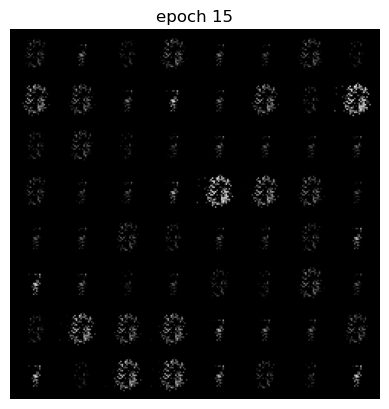

Epoch 15 of 200
Generator loss: 2.22383720, Discriminator loss: 0.87874690


118it [00:04, 25.85it/s]                                                                                                        


Epoch 16 of 200
Generator loss: 1.51591705, Discriminator loss: 0.98727724


118it [00:04, 26.01it/s]                                                                                                        


Epoch 17 of 200
Generator loss: 1.84056715, Discriminator loss: 0.90613652


118it [00:04, 25.87it/s]                                                                                                        


Epoch 18 of 200
Generator loss: 2.78576072, Discriminator loss: 0.61565897


118it [00:04, 26.18it/s]                                                                                                        


Epoch 19 of 200
Generator loss: 3.05590711, Discriminator loss: 0.54633634


118it [00:04, 25.83it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


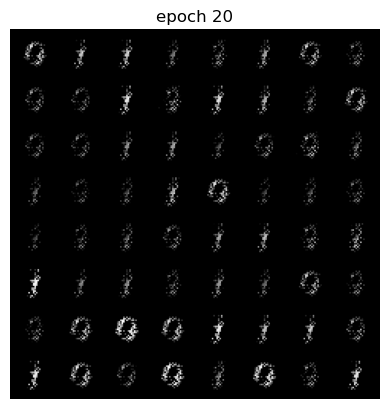

Epoch 20 of 200
Generator loss: 3.51145389, Discriminator loss: 0.60673641


118it [00:04, 25.05it/s]                                                                                                        


Epoch 21 of 200
Generator loss: 3.17498377, Discriminator loss: 0.57555939


118it [00:04, 24.36it/s]                                                                                                        


Epoch 22 of 200
Generator loss: 3.09305512, Discriminator loss: 0.54814779


118it [00:04, 25.26it/s]                                                                                                        


Epoch 23 of 200
Generator loss: 2.93563095, Discriminator loss: 0.55100329


118it [00:04, 25.79it/s]                                                                                                        


Epoch 24 of 200
Generator loss: 2.66964884, Discriminator loss: 0.69520127


118it [00:04, 26.09it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


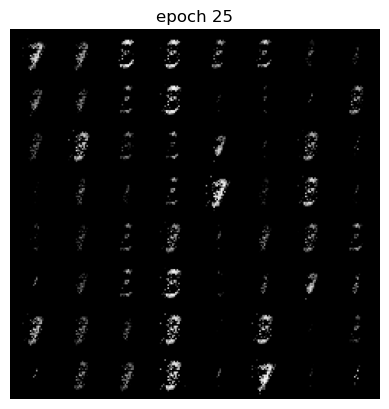

Epoch 25 of 200
Generator loss: 2.51066022, Discriminator loss: 0.58635340


118it [00:04, 25.89it/s]                                                                                                        


Epoch 26 of 200
Generator loss: 2.67215456, Discriminator loss: 0.61633572


118it [00:04, 25.86it/s]                                                                                                        


Epoch 27 of 200
Generator loss: 2.26086446, Discriminator loss: 0.68866733


118it [00:04, 25.91it/s]                                                                                                        


Epoch 28 of 200
Generator loss: 2.36943762, Discriminator loss: 0.59948614


118it [00:04, 25.82it/s]                                                                                                        


Epoch 29 of 200
Generator loss: 3.34633986, Discriminator loss: 0.43288241


118it [00:04, 26.04it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


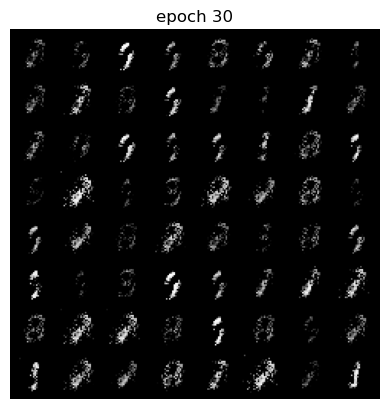

Epoch 30 of 200
Generator loss: 2.68324213, Discriminator loss: 0.60308534


118it [00:04, 25.80it/s]                                                                                                        


Epoch 31 of 200
Generator loss: 2.71315221, Discriminator loss: 0.59342871


118it [00:04, 25.92it/s]                                                                                                        


Epoch 32 of 200
Generator loss: 2.92185517, Discriminator loss: 0.61682889


118it [00:04, 25.94it/s]                                                                                                        


Epoch 33 of 200
Generator loss: 2.71514863, Discriminator loss: 0.56717904


118it [00:04, 26.22it/s]                                                                                                        


Epoch 34 of 200
Generator loss: 3.05256033, Discriminator loss: 0.45420365


118it [00:04, 25.53it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


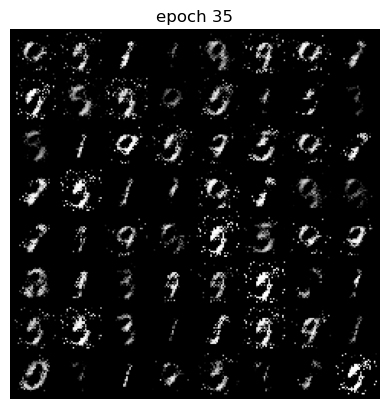

Epoch 35 of 200
Generator loss: 3.15886913, Discriminator loss: 0.42429110


118it [00:04, 24.72it/s]                                                                                                        


Epoch 36 of 200
Generator loss: 3.40378133, Discriminator loss: 0.46915183


118it [00:04, 25.41it/s]                                                                                                        


Epoch 37 of 200
Generator loss: 3.10446480, Discriminator loss: 0.54033313


118it [00:04, 26.21it/s]                                                                                                        


Epoch 38 of 200
Generator loss: 2.52777595, Discriminator loss: 0.60557829


118it [00:04, 26.06it/s]                                                                                                        


Epoch 39 of 200
Generator loss: 2.80210163, Discriminator loss: 0.53371887


118it [00:04, 26.38it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


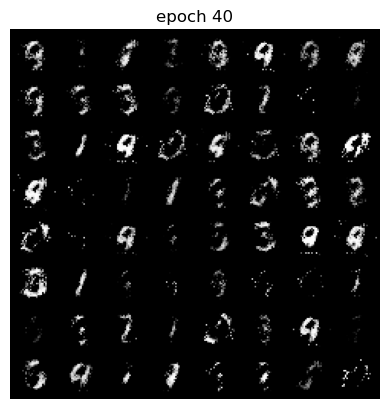

Epoch 40 of 200
Generator loss: 2.88982713, Discriminator loss: 0.46837036


118it [00:04, 26.06it/s]                                                                                                        


Epoch 41 of 200
Generator loss: 2.86892803, Discriminator loss: 0.52615036


118it [00:04, 26.39it/s]                                                                                                        


Epoch 42 of 200
Generator loss: 2.98498948, Discriminator loss: 0.53357333


118it [00:04, 26.21it/s]                                                                                                        


Epoch 43 of 200
Generator loss: 2.58603785, Discriminator loss: 0.62532705


118it [00:04, 25.85it/s]                                                                                                        


Epoch 44 of 200
Generator loss: 2.54602223, Discriminator loss: 0.63320013


118it [00:04, 26.39it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


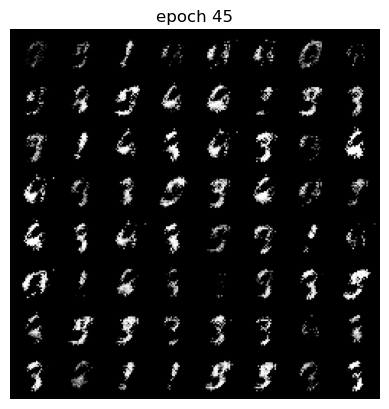

Epoch 45 of 200
Generator loss: 2.87831717, Discriminator loss: 0.59657698


118it [00:04, 26.10it/s]                                                                                                        


Epoch 46 of 200
Generator loss: 3.01920734, Discriminator loss: 0.56066293


118it [00:04, 26.34it/s]                                                                                                        


Epoch 47 of 200
Generator loss: 2.83064284, Discriminator loss: 0.56624291


118it [00:04, 26.04it/s]                                                                                                        


Epoch 48 of 200
Generator loss: 2.58089175, Discriminator loss: 0.59621183


118it [00:04, 26.21it/s]                                                                                                        


Epoch 49 of 200
Generator loss: 2.65518386, Discriminator loss: 0.57552351


118it [00:04, 26.10it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


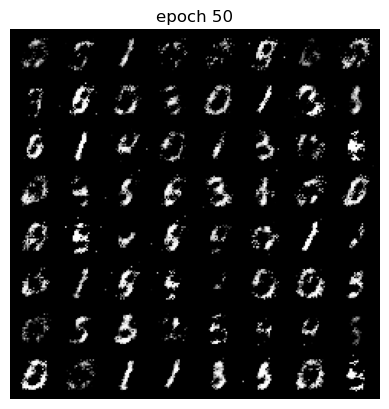

Epoch 50 of 200
Generator loss: 2.59827062, Discriminator loss: 0.58465591


118it [00:04, 26.20it/s]                                                                                                        


Epoch 51 of 200
Generator loss: 2.59361232, Discriminator loss: 0.61406517


118it [00:04, 26.21it/s]                                                                                                        


Epoch 52 of 200
Generator loss: 2.61110852, Discriminator loss: 0.56849079


118it [00:04, 26.03it/s]                                                                                                        


Epoch 53 of 200
Generator loss: 2.39345135, Discriminator loss: 0.70322234


118it [00:04, 26.29it/s]                                                                                                        


Epoch 54 of 200
Generator loss: 2.39051481, Discriminator loss: 0.68290823


118it [00:04, 26.12it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


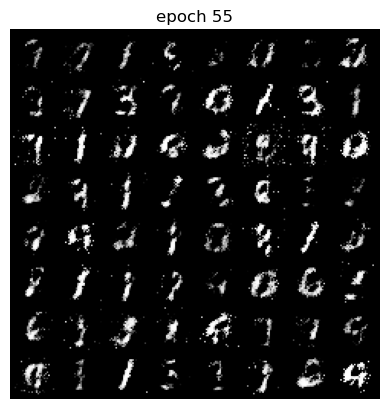

Epoch 55 of 200
Generator loss: 2.43939303, Discriminator loss: 0.62084193


118it [00:04, 26.41it/s]                                                                                                        


Epoch 56 of 200
Generator loss: 2.26996252, Discriminator loss: 0.70639322


118it [00:04, 25.96it/s]                                                                                                        


Epoch 57 of 200
Generator loss: 1.92323422, Discriminator loss: 0.79826002


118it [00:04, 26.07it/s]                                                                                                        


Epoch 58 of 200
Generator loss: 2.31127199, Discriminator loss: 0.71925690


118it [00:04, 25.66it/s]                                                                                                        


Epoch 59 of 200
Generator loss: 2.31976214, Discriminator loss: 0.69823124


118it [00:04, 26.28it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


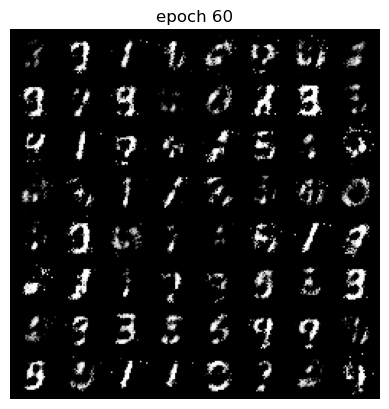

Epoch 60 of 200
Generator loss: 2.41877348, Discriminator loss: 0.69044609


118it [00:04, 25.95it/s]                                                                                                        


Epoch 61 of 200
Generator loss: 2.23791633, Discriminator loss: 0.69213270


118it [00:04, 25.27it/s]                                                                                                        


Epoch 62 of 200
Generator loss: 2.40132564, Discriminator loss: 0.68136027


118it [00:04, 25.49it/s]                                                                                                        


Epoch 63 of 200
Generator loss: 2.30665444, Discriminator loss: 0.70587974


118it [00:04, 26.26it/s]                                                                                                        


Epoch 64 of 200
Generator loss: 2.25540242, Discriminator loss: 0.75214425


118it [00:04, 26.53it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


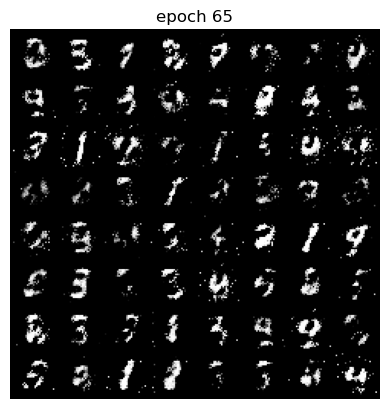

Epoch 65 of 200
Generator loss: 2.05733047, Discriminator loss: 0.79025262


118it [00:04, 26.44it/s]                                                                                                        


Epoch 66 of 200
Generator loss: 2.11601876, Discriminator loss: 0.81345523


118it [00:04, 26.70it/s]                                                                                                        


Epoch 67 of 200
Generator loss: 2.15375145, Discriminator loss: 0.70458397


118it [00:04, 26.45it/s]                                                                                                        


Epoch 68 of 200
Generator loss: 2.14423481, Discriminator loss: 0.72467446


118it [00:04, 26.51it/s]                                                                                                        


Epoch 69 of 200
Generator loss: 2.16421112, Discriminator loss: 0.75154771


118it [00:04, 26.47it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


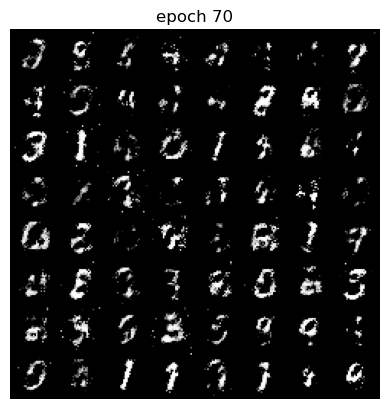

Epoch 70 of 200
Generator loss: 2.05790521, Discriminator loss: 0.74645809


118it [00:04, 25.99it/s]                                                                                                        


Epoch 71 of 200
Generator loss: 2.07129526, Discriminator loss: 0.77520973


118it [00:04, 26.51it/s]                                                                                                        


Epoch 72 of 200
Generator loss: 1.89326660, Discriminator loss: 0.85125554


118it [00:04, 26.69it/s]                                                                                                        


Epoch 73 of 200
Generator loss: 1.88117585, Discriminator loss: 0.84023424


118it [00:04, 26.55it/s]                                                                                                        


Epoch 74 of 200
Generator loss: 1.98336212, Discriminator loss: 0.77428278


118it [00:04, 25.86it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


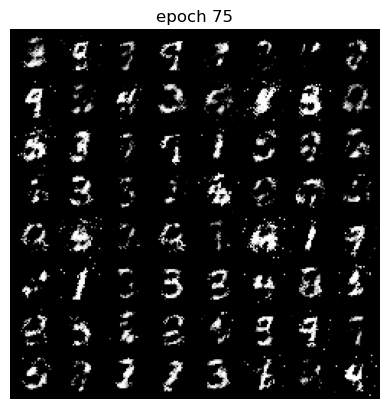

Epoch 75 of 200
Generator loss: 2.08968158, Discriminator loss: 0.75234976


118it [00:04, 26.50it/s]                                                                                                        


Epoch 76 of 200
Generator loss: 2.02784768, Discriminator loss: 0.82416829


118it [00:04, 26.45it/s]                                                                                                        


Epoch 77 of 200
Generator loss: 1.97942444, Discriminator loss: 0.77713370


118it [00:04, 26.61it/s]                                                                                                        


Epoch 78 of 200
Generator loss: 1.89472877, Discriminator loss: 0.83170657


118it [00:04, 25.70it/s]                                                                                                        


Epoch 79 of 200
Generator loss: 1.91275690, Discriminator loss: 0.80662432


118it [00:04, 25.47it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


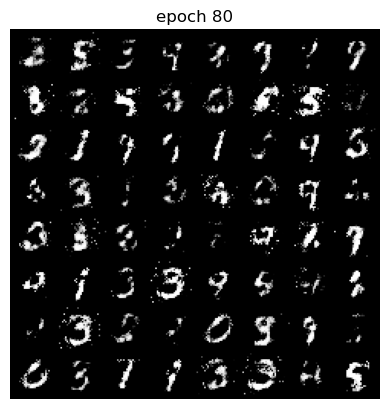

Epoch 80 of 200
Generator loss: 1.85210000, Discriminator loss: 0.82910692


118it [00:04, 26.08it/s]                                                                                                        


Epoch 81 of 200
Generator loss: 1.90845744, Discriminator loss: 0.86873524


118it [00:04, 26.71it/s]                                                                                                        


Epoch 82 of 200
Generator loss: 1.93907031, Discriminator loss: 0.79641264


118it [00:04, 26.49it/s]                                                                                                        


Epoch 83 of 200
Generator loss: 1.89611218, Discriminator loss: 0.85808239


118it [00:04, 26.47it/s]                                                                                                        


Epoch 84 of 200
Generator loss: 1.86591402, Discriminator loss: 0.84090315


118it [00:04, 25.39it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


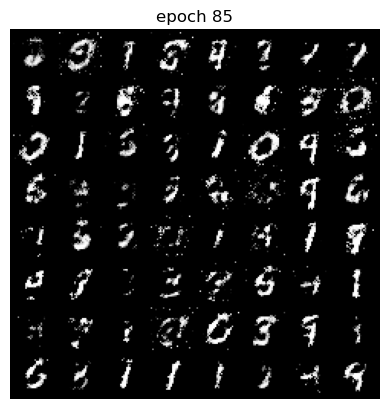

Epoch 85 of 200
Generator loss: 1.75233776, Discriminator loss: 0.84366481


118it [00:04, 26.00it/s]                                                                                                        


Epoch 86 of 200
Generator loss: 1.76900165, Discriminator loss: 0.86444991


118it [00:04, 26.66it/s]                                                                                                        


Epoch 87 of 200
Generator loss: 1.93256462, Discriminator loss: 0.84217348


118it [00:04, 26.38it/s]                                                                                                        


Epoch 88 of 200
Generator loss: 1.94111524, Discriminator loss: 0.84916994


118it [00:04, 26.29it/s]                                                                                                        


Epoch 89 of 200
Generator loss: 1.86709267, Discriminator loss: 0.82950393


118it [00:04, 26.30it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


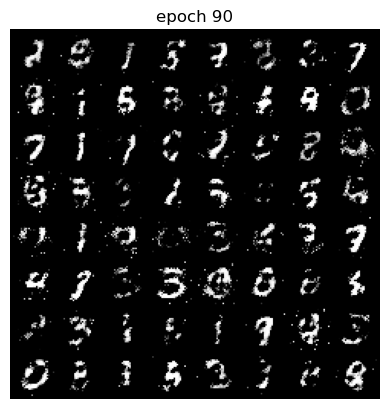

Epoch 90 of 200
Generator loss: 1.79434677, Discriminator loss: 0.85440007


118it [00:04, 26.14it/s]                                                                                                        


Epoch 91 of 200
Generator loss: 1.84890964, Discriminator loss: 0.84279527


118it [00:04, 25.98it/s]                                                                                                        


Epoch 92 of 200
Generator loss: 1.71213045, Discriminator loss: 0.89556871


118it [00:04, 26.18it/s]                                                                                                        


Epoch 93 of 200
Generator loss: 1.84667980, Discriminator loss: 0.83440674


118it [00:04, 26.25it/s]                                                                                                        


Epoch 94 of 200
Generator loss: 1.82225717, Discriminator loss: 0.86746510


118it [00:04, 26.48it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


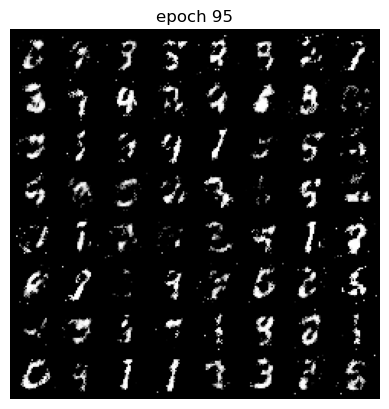

Epoch 95 of 200
Generator loss: 1.78728846, Discriminator loss: 0.91858397


118it [00:04, 26.36it/s]                                                                                                        


Epoch 96 of 200
Generator loss: 1.67753077, Discriminator loss: 0.89090141


118it [00:04, 26.03it/s]                                                                                                        


Epoch 97 of 200
Generator loss: 1.74070830, Discriminator loss: 0.83638740


118it [00:04, 26.62it/s]                                                                                                        


Epoch 98 of 200
Generator loss: 1.84222407, Discriminator loss: 0.85713161


118it [00:04, 26.45it/s]                                                                                                        


Epoch 99 of 200
Generator loss: 1.84245943, Discriminator loss: 0.85014805


118it [00:04, 26.75it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


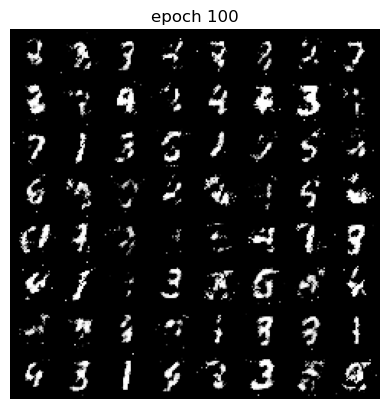

Epoch 100 of 200
Generator loss: 1.78073620, Discriminator loss: 0.86996815


118it [00:04, 26.18it/s]                                                                                                        


Epoch 101 of 200
Generator loss: 1.73144742, Discriminator loss: 0.88275117


118it [00:04, 26.47it/s]                                                                                                        


Epoch 102 of 200
Generator loss: 1.69957868, Discriminator loss: 0.91490747


118it [00:04, 26.43it/s]                                                                                                        


Epoch 103 of 200
Generator loss: 1.70672799, Discriminator loss: 0.88509118


118it [00:04, 26.63it/s]                                                                                                        


Epoch 104 of 200
Generator loss: 1.71445468, Discriminator loss: 0.93414315


118it [00:04, 26.63it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


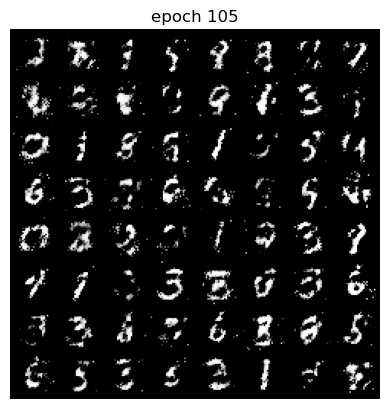

Epoch 105 of 200
Generator loss: 1.78414497, Discriminator loss: 0.89095482


118it [00:04, 26.35it/s]                                                                                                        


Epoch 106 of 200
Generator loss: 1.74555351, Discriminator loss: 0.85190620


118it [00:04, 26.32it/s]                                                                                                        


Epoch 107 of 200
Generator loss: 1.69692775, Discriminator loss: 0.90776968


118it [00:04, 26.48it/s]                                                                                                        


Epoch 108 of 200
Generator loss: 1.72316905, Discriminator loss: 0.90114277


118it [00:04, 26.74it/s]                                                                                                        


Epoch 109 of 200
Generator loss: 1.66602030, Discriminator loss: 0.94268389


118it [00:04, 26.51it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


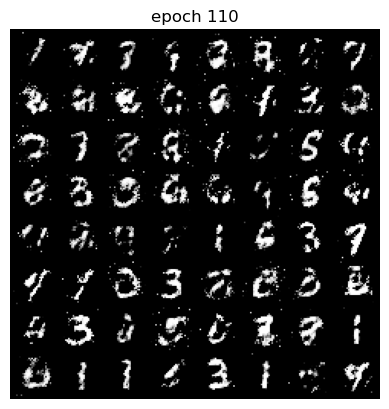

Epoch 110 of 200
Generator loss: 1.73856571, Discriminator loss: 0.85730499


118it [00:04, 26.29it/s]                                                                                                        


Epoch 111 of 200
Generator loss: 1.65016468, Discriminator loss: 0.91158036


118it [00:04, 26.01it/s]                                                                                                        


Epoch 112 of 200
Generator loss: 1.65128641, Discriminator loss: 0.91420890


118it [00:04, 25.55it/s]                                                                                                        


Epoch 113 of 200
Generator loss: 1.78511690, Discriminator loss: 0.88728471


118it [00:04, 26.61it/s]                                                                                                        


Epoch 114 of 200
Generator loss: 1.73297534, Discriminator loss: 0.88624087


118it [00:04, 26.38it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


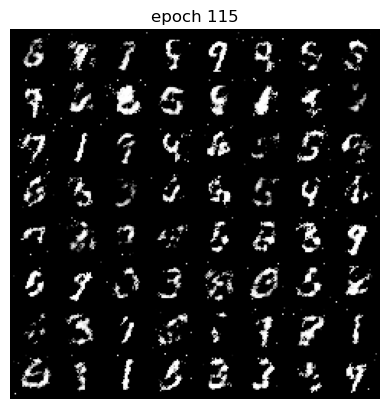

Epoch 115 of 200
Generator loss: 1.62155896, Discriminator loss: 0.92807980


118it [00:04, 26.25it/s]                                                                                                        


Epoch 116 of 200
Generator loss: 1.60514080, Discriminator loss: 0.96473967


118it [00:04, 26.14it/s]                                                                                                        


Epoch 117 of 200
Generator loss: 1.55142684, Discriminator loss: 0.94563371


118it [00:04, 26.60it/s]                                                                                                        


Epoch 118 of 200
Generator loss: 1.57801041, Discriminator loss: 0.93484032


118it [00:04, 26.20it/s]                                                                                                        


Epoch 119 of 200
Generator loss: 1.60127326, Discriminator loss: 0.94964604


118it [00:04, 26.69it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


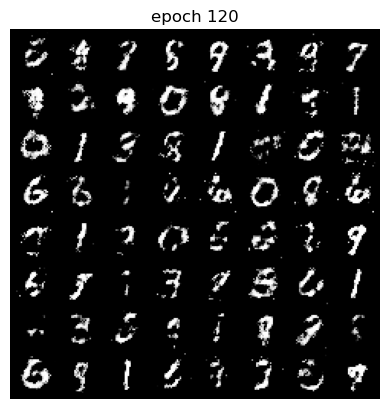

Epoch 120 of 200
Generator loss: 1.55470968, Discriminator loss: 0.94307758


118it [00:04, 26.34it/s]                                                                                                        


Epoch 121 of 200
Generator loss: 1.50419771, Discriminator loss: 0.96555645


118it [00:04, 26.75it/s]                                                                                                        


Epoch 122 of 200
Generator loss: 1.56590184, Discriminator loss: 0.93750511


118it [00:04, 26.30it/s]                                                                                                        


Epoch 123 of 200
Generator loss: 1.56555752, Discriminator loss: 0.97164401


118it [00:04, 26.59it/s]                                                                                                        


Epoch 124 of 200
Generator loss: 1.52195625, Discriminator loss: 0.96964823


118it [00:04, 27.05it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


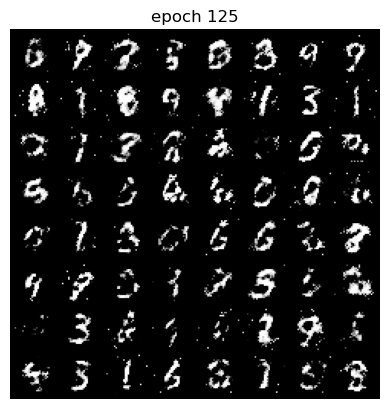

Epoch 125 of 200
Generator loss: 1.51256566, Discriminator loss: 0.93215390


118it [00:04, 26.81it/s]                                                                                                        


Epoch 126 of 200
Generator loss: 1.57699998, Discriminator loss: 0.91045256


118it [00:04, 27.01it/s]                                                                                                        


Epoch 127 of 200
Generator loss: 1.64938686, Discriminator loss: 0.93624230


118it [00:04, 26.57it/s]                                                                                                        


Epoch 128 of 200
Generator loss: 1.58854197, Discriminator loss: 0.94690288


118it [00:04, 26.81it/s]                                                                                                        


Epoch 129 of 200
Generator loss: 1.65841867, Discriminator loss: 0.89981499


118it [00:04, 26.83it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


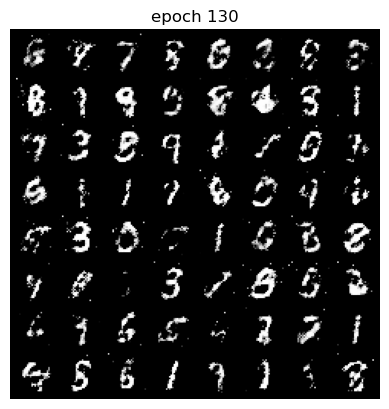

Epoch 130 of 200
Generator loss: 1.62864531, Discriminator loss: 0.91758424


118it [00:04, 25.15it/s]                                                                                                        


Epoch 131 of 200
Generator loss: 1.64404573, Discriminator loss: 0.94310333


118it [00:04, 26.46it/s]                                                                                                        


Epoch 132 of 200
Generator loss: 1.58710400, Discriminator loss: 0.93210714


118it [00:04, 27.02it/s]                                                                                                        


Epoch 133 of 200
Generator loss: 1.64448202, Discriminator loss: 0.89725602


118it [00:04, 26.80it/s]                                                                                                        


Epoch 134 of 200
Generator loss: 1.56160333, Discriminator loss: 0.93931098


118it [00:04, 26.70it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


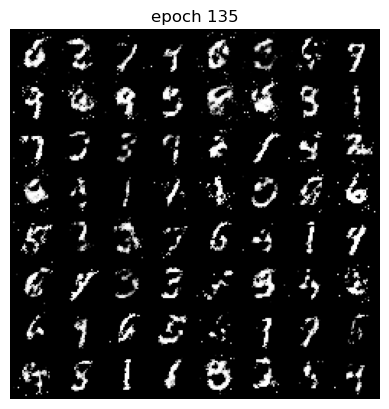

Epoch 135 of 200
Generator loss: 1.49969835, Discriminator loss: 0.96052684


118it [00:04, 26.99it/s]                                                                                                        


Epoch 136 of 200
Generator loss: 1.55858284, Discriminator loss: 0.96003443


118it [00:04, 26.66it/s]                                                                                                        


Epoch 137 of 200
Generator loss: 1.61560837, Discriminator loss: 0.92457236


118it [00:04, 26.78it/s]                                                                                                        


Epoch 138 of 200
Generator loss: 1.64596229, Discriminator loss: 0.90680301


118it [00:04, 26.55it/s]                                                                                                        


Epoch 139 of 200
Generator loss: 1.61293366, Discriminator loss: 0.93181566


118it [00:04, 27.02it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


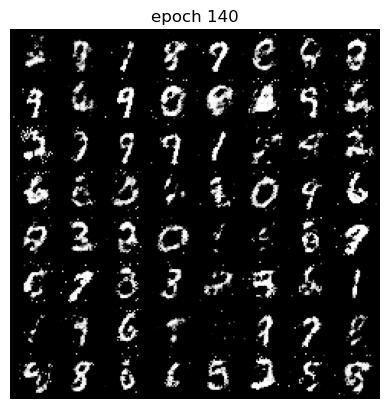

Epoch 140 of 200
Generator loss: 1.64825064, Discriminator loss: 0.94549892


118it [00:04, 26.86it/s]                                                                                                        


Epoch 141 of 200
Generator loss: 1.51249970, Discriminator loss: 0.98460436


118it [00:04, 26.83it/s]                                                                                                        


Epoch 142 of 200
Generator loss: 1.50314584, Discriminator loss: 0.95183506


118it [00:04, 26.76it/s]                                                                                                        


Epoch 143 of 200
Generator loss: 1.49209961, Discriminator loss: 0.97566209


118it [00:04, 26.25it/s]                                                                                                        


Epoch 144 of 200
Generator loss: 1.54345727, Discriminator loss: 0.96692872


118it [00:04, 26.50it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


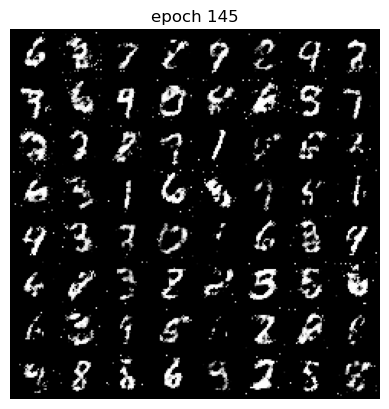

Epoch 145 of 200
Generator loss: 1.44912538, Discriminator loss: 0.98616718


118it [00:04, 26.15it/s]                                                                                                        


Epoch 146 of 200
Generator loss: 1.47834736, Discriminator loss: 0.99393172


118it [00:04, 26.65it/s]                                                                                                        


Epoch 147 of 200
Generator loss: 1.45226348, Discriminator loss: 0.98449538


118it [00:04, 26.57it/s]                                                                                                        


Epoch 148 of 200
Generator loss: 1.55165107, Discriminator loss: 0.95542373


118it [00:04, 26.62it/s]                                                                                                        


Epoch 149 of 200
Generator loss: 1.57603231, Discriminator loss: 0.94394197


118it [00:04, 26.62it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


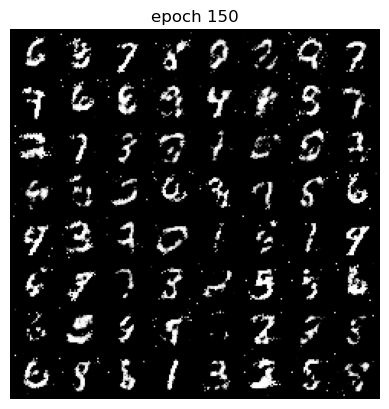

Epoch 150 of 200
Generator loss: 1.49879853, Discriminator loss: 0.96728008


118it [00:04, 26.58it/s]                                                                                                        


Epoch 151 of 200
Generator loss: 1.53307465, Discriminator loss: 0.93512505


118it [00:04, 26.97it/s]                                                                                                        


Epoch 152 of 200
Generator loss: 1.47913557, Discriminator loss: 0.98537631


118it [00:04, 26.79it/s]                                                                                                        


Epoch 153 of 200
Generator loss: 1.46465292, Discriminator loss: 0.97690802


118it [00:04, 26.86it/s]                                                                                                        


Epoch 154 of 200
Generator loss: 1.49549193, Discriminator loss: 1.01610284


118it [00:04, 26.26it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


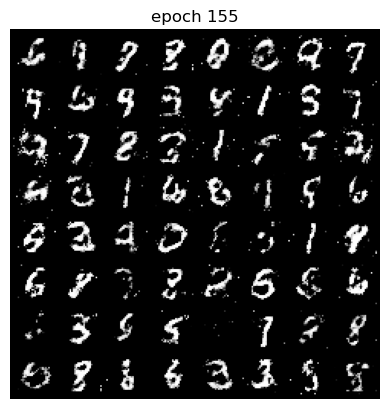

Epoch 155 of 200
Generator loss: 1.55191098, Discriminator loss: 0.96758309


118it [00:04, 26.48it/s]                                                                                                        


Epoch 156 of 200
Generator loss: 1.49281551, Discriminator loss: 0.99502144


118it [00:04, 26.51it/s]                                                                                                        


Epoch 157 of 200
Generator loss: 1.46818889, Discriminator loss: 1.00573268


118it [00:04, 26.68it/s]                                                                                                        


Epoch 158 of 200
Generator loss: 1.45892778, Discriminator loss: 0.99687947


118it [00:04, 26.67it/s]                                                                                                        


Epoch 159 of 200
Generator loss: 1.45009424, Discriminator loss: 1.00529716


118it [00:04, 26.98it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


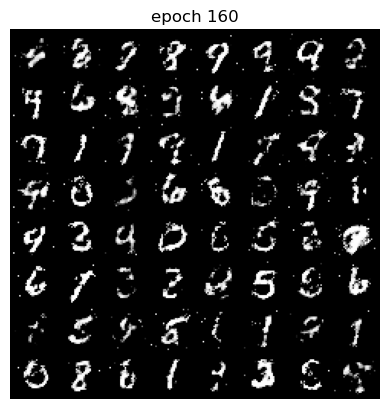

Epoch 160 of 200
Generator loss: 1.45274838, Discriminator loss: 0.99581272


118it [00:04, 26.70it/s]                                                                                                        


Epoch 161 of 200
Generator loss: 1.46035283, Discriminator loss: 1.00693205


118it [00:04, 26.64it/s]                                                                                                        


Epoch 162 of 200
Generator loss: 1.44083154, Discriminator loss: 0.99361471


118it [00:04, 26.89it/s]                                                                                                        


Epoch 163 of 200
Generator loss: 1.46838481, Discriminator loss: 0.98559708


118it [00:04, 26.69it/s]                                                                                                        


Epoch 164 of 200
Generator loss: 1.47063070, Discriminator loss: 1.00522106


118it [00:04, 26.68it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


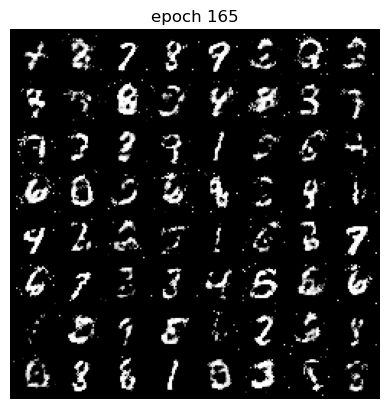

Epoch 165 of 200
Generator loss: 1.48591296, Discriminator loss: 0.99953474


118it [00:04, 26.47it/s]                                                                                                        


Epoch 166 of 200
Generator loss: 1.45859809, Discriminator loss: 0.99957478


118it [00:04, 26.87it/s]                                                                                                        


Epoch 167 of 200
Generator loss: 1.48964110, Discriminator loss: 0.99008465


118it [00:04, 26.85it/s]                                                                                                        


Epoch 168 of 200
Generator loss: 1.46389659, Discriminator loss: 1.01407813


118it [00:04, 26.61it/s]                                                                                                        


Epoch 169 of 200
Generator loss: 1.43535394, Discriminator loss: 0.99855139


118it [00:04, 26.64it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


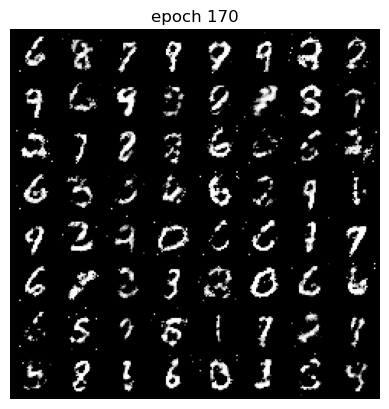

Epoch 170 of 200
Generator loss: 1.41679027, Discriminator loss: 1.01293624


118it [00:04, 26.25it/s]                                                                                                        


Epoch 171 of 200
Generator loss: 1.38904385, Discriminator loss: 1.03481339


118it [00:04, 26.59it/s]                                                                                                        


Epoch 172 of 200
Generator loss: 1.39395632, Discriminator loss: 1.03181465


118it [00:04, 26.57it/s]                                                                                                        


Epoch 173 of 200
Generator loss: 1.41955284, Discriminator loss: 1.03655121


118it [00:04, 26.91it/s]                                                                                                        


Epoch 174 of 200
Generator loss: 1.41452977, Discriminator loss: 1.03971196


118it [00:04, 26.78it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


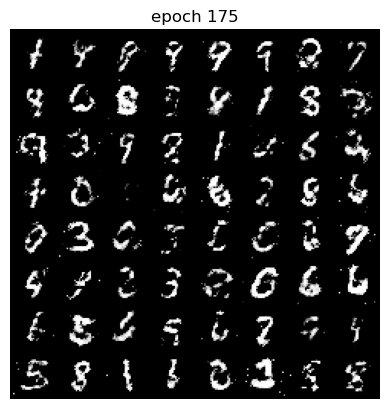

Epoch 175 of 200
Generator loss: 1.39832645, Discriminator loss: 1.03092438


118it [00:04, 26.82it/s]                                                                                                        


Epoch 176 of 200
Generator loss: 1.38881186, Discriminator loss: 1.03171286


118it [00:04, 26.68it/s]                                                                                                        


Epoch 177 of 200
Generator loss: 1.42140563, Discriminator loss: 1.01216790


118it [00:04, 26.51it/s]                                                                                                        


Epoch 178 of 200
Generator loss: 1.41309710, Discriminator loss: 1.02839585


118it [00:04, 27.03it/s]                                                                                                        


Epoch 179 of 200
Generator loss: 1.39367267, Discriminator loss: 1.05163033


118it [00:04, 26.81it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


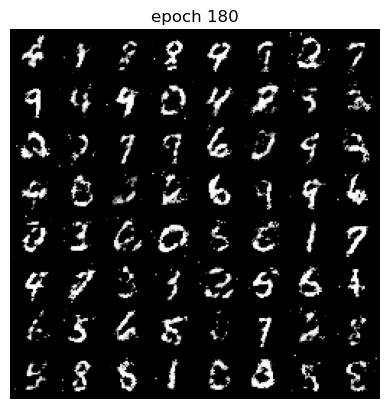

Epoch 180 of 200
Generator loss: 1.31126813, Discriminator loss: 1.05684925


118it [00:04, 26.94it/s]                                                                                                        


Epoch 181 of 200
Generator loss: 1.36079562, Discriminator loss: 1.03479166


118it [00:04, 26.47it/s]                                                                                                        


Epoch 182 of 200
Generator loss: 1.38020879, Discriminator loss: 1.01840461


118it [00:04, 26.68it/s]                                                                                                        


Epoch 183 of 200
Generator loss: 1.39652884, Discriminator loss: 1.02541917


118it [00:04, 26.85it/s]                                                                                                        


Epoch 184 of 200
Generator loss: 1.35984654, Discriminator loss: 1.05224404


118it [00:04, 27.11it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


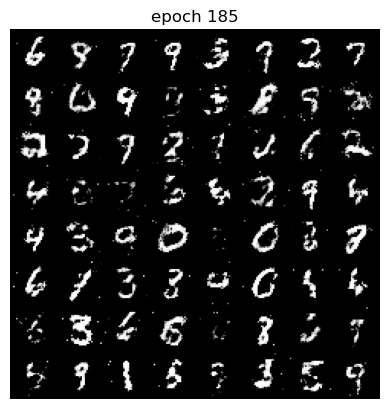

Epoch 185 of 200
Generator loss: 1.38642250, Discriminator loss: 1.05026455


118it [00:04, 26.99it/s]                                                                                                        


Epoch 186 of 200
Generator loss: 1.34205177, Discriminator loss: 1.04913269


118it [00:04, 26.78it/s]                                                                                                        


Epoch 187 of 200
Generator loss: 1.34081625, Discriminator loss: 1.05246067


118it [00:04, 26.94it/s]                                                                                                        


Epoch 188 of 200
Generator loss: 1.34054019, Discriminator loss: 1.05039922


118it [00:04, 26.79it/s]                                                                                                        


Epoch 189 of 200
Generator loss: 1.34149727, Discriminator loss: 1.05897091


118it [00:04, 27.18it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


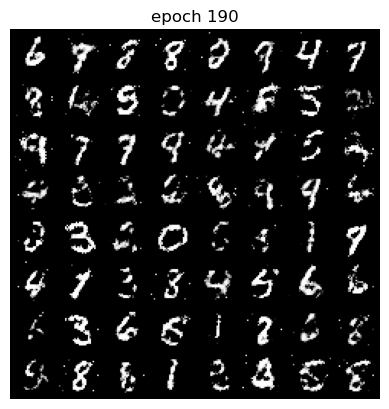

Epoch 190 of 200
Generator loss: 1.38394905, Discriminator loss: 1.04478474


118it [00:04, 26.91it/s]                                                                                                        


Epoch 191 of 200
Generator loss: 1.36771923, Discriminator loss: 1.05759154


118it [00:04, 27.07it/s]                                                                                                        


Epoch 192 of 200
Generator loss: 1.36748124, Discriminator loss: 1.05454021


118it [00:04, 26.77it/s]                                                                                                        


Epoch 193 of 200
Generator loss: 1.29507993, Discriminator loss: 1.05640604


118it [00:04, 27.29it/s]                                                                                                        


Epoch 194 of 200
Generator loss: 1.26596794, Discriminator loss: 1.07690373


118it [00:04, 27.25it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


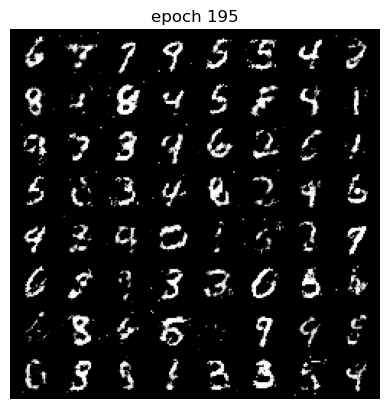

Epoch 195 of 200
Generator loss: 1.34680352, Discriminator loss: 1.05919947


118it [00:04, 26.97it/s]                                                                                                        


Epoch 196 of 200
Generator loss: 1.30484438, Discriminator loss: 1.07147058


118it [00:04, 27.00it/s]                                                                                                        


Epoch 197 of 200
Generator loss: 1.26981825, Discriminator loss: 1.07960727


118it [00:04, 26.94it/s]                                                                                                        


Epoch 198 of 200
Generator loss: 1.27204640, Discriminator loss: 1.08213213


118it [00:04, 27.25it/s]                                                                                                        


Epoch 199 of 200
Generator loss: 1.29133584, Discriminator loss: 1.06877666


118it [00:04, 27.12it/s]                                                                                                        
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


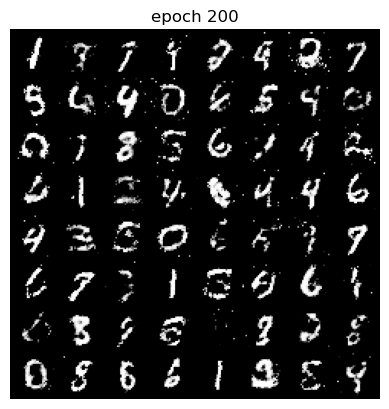

Epoch 200 of 200
Generator loss: 1.32379375, Discriminator loss: 1.08559454


In [15]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return (criterion(output[true_label == 1], true_label[true_label == 1])
            + criterion(output[true_label == 0], true_label[true_label == 0]))
    
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        X, Y = data
        X, Y = X.to(device), Y.to(device)
        
        # Optimize Discriminator
        for _ in range(k):
            # Forward Pass
            # Output
            y_fake = torch.randint(0, 10, (sample_size,)) # generate random digits
            x_fake = generator(create_noise(sample_size, nz), y_fake) # generate images using noise
            x_inputs = torch.cat((X, x_fake))
            y_inputs = torch.cat((Y, y_fake))
            output = discriminator(x_inputs, y_inputs)
            labels = torch.cat((label_real(X.shape[0]), label_fake(sample_size)))
            
            # Loss
            d_loss = discriminator_loss(output, labels)
            
            # Backward pass
            optim_d.zero_grad()
            d_loss.backward()
            optim_d.step()
            
        # Optimize Generator
        # Forward Pass
        y_fake = torch.randint(0, 10, (sample_size,)) # generate random digits
        x_fake = generator(create_noise(sample_size, nz), y_fake) # generate images using noise
        output = discriminator(x_fake, y_fake)
        labels = label_real(sample_size)
        
        # Loss
        g_loss = generator_loss(output, labels)
        
        # Backward Pass
        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()
        
        # Accumulate losses
        loss_g += g_loss.item()
        # Do not accumulate losses inside the for-k loop
        loss_d += d_loss.item() # Last iteration loss
    
        ######################################
    
    
    # create the final fake image for the epoch
    y_gen = torch.randint(0, 10, (sample_size,)) # generate random digits
    generated_img = generator(noise, y_gen).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    
    sch_d.step()

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

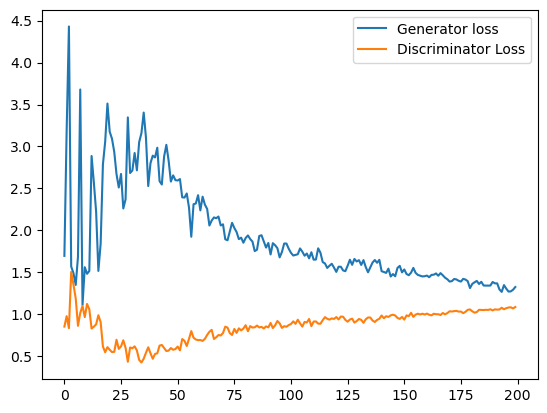

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')